In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

import helper_functions
from model_run import *

C:\Users\hanic\AppData\Local\Temp\ipykernel_32976\1147271186.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


A simplifying diagram for how the gravity and Bell models are computed in practice:

<img src="ideas/gravity, bell pipeline.png" width="800"/>

In [2]:
import pickle
with open("networks/Hungary_2022_road_network_connected.pickle", "rb") as f:
    G = pickle.load(f)

ksh_stats = pd.read_csv("data/sources/KSH/KSHSettlList_settlID_settlname_pop_lat_lon.csv")
ksh_flows_16 = pd.read_csv("data/sources/KSH/flows_16_cities.csv")
odm_gravity_df = pd.read_csv("computing/odm/ODM_16_cities_gravity_unfitted_unordered.csv")

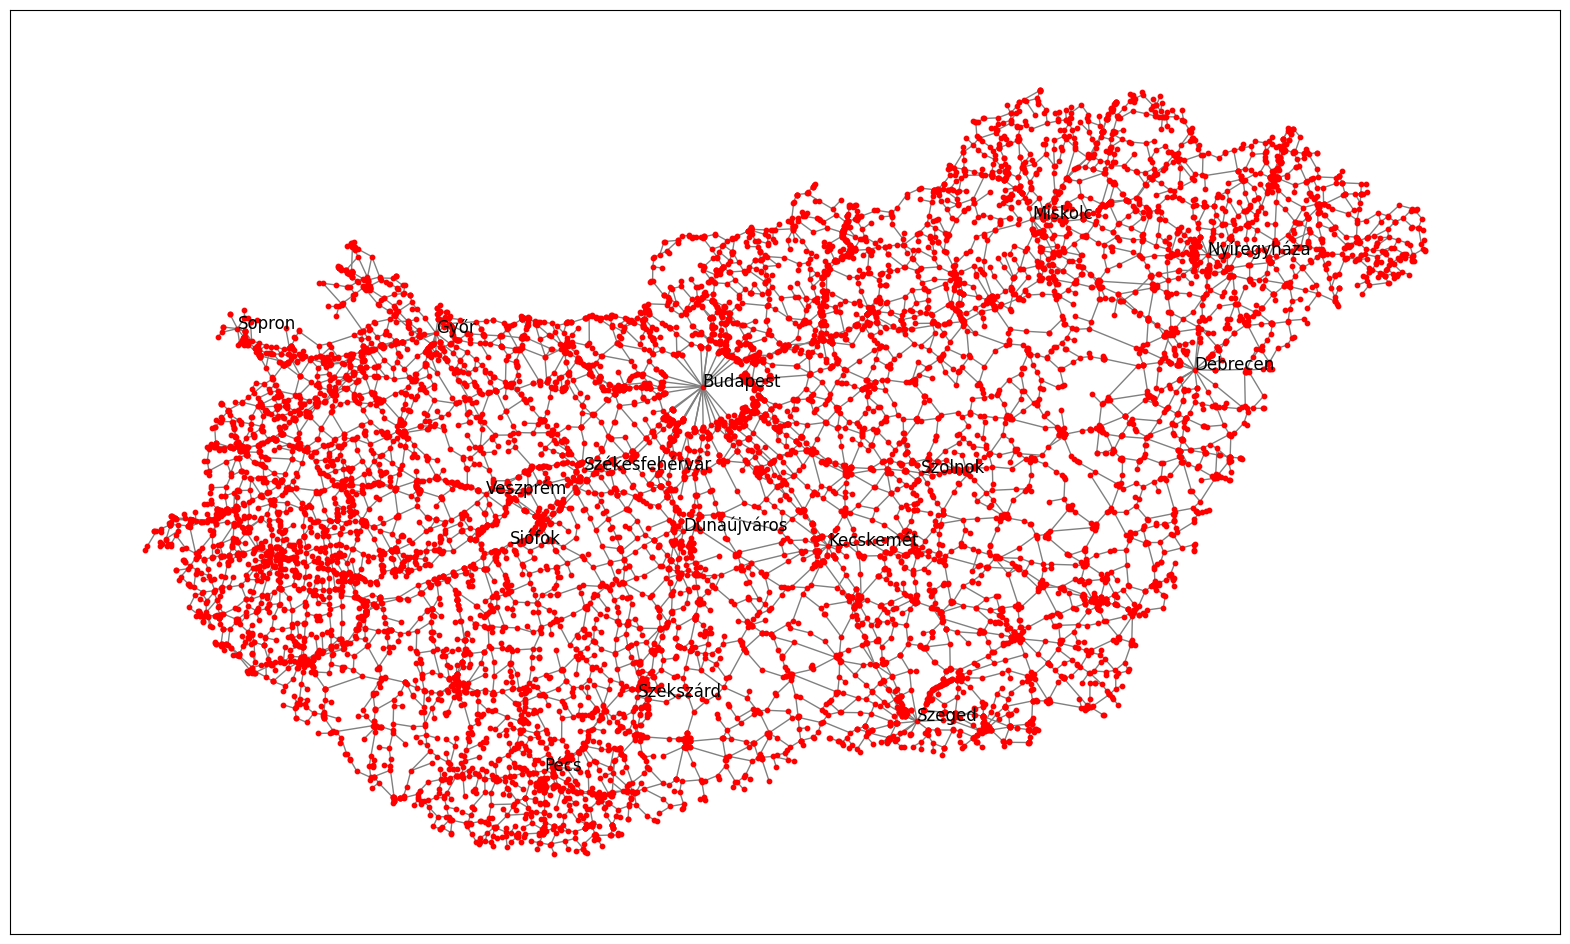

In [3]:
import matplotlib.cm
import matplotlib.colors
color_map = matplotlib.colormaps.get_cmap('prism')
components = nx.connected_components(G)
plt.figure(figsize=(20, 12))
for i, component in enumerate((list(nx.connected_components(G)))):
    subgraph = G.subgraph(component)
    pos = {node: (attrs['x'], attrs['y']) for node, attrs in subgraph.nodes(data=True)}
    nx.draw_networkx(subgraph, pos=pos, node_color=[color_map(i)], with_labels=False, edge_color='gray', node_size=10,)

#Plot the nodes with "name" attribute that have ignore=False
for node, attrs in G.nodes(data=True):
    if not attrs.get('ignore', True):
        #plt.scatter(attrs['x'], attrs['y'], c='black', s=300)
        plt.text(attrs['x'], attrs['y'], attrs['location_name'], fontsize=12)
plt.show()

In [4]:
def generate_id_dicts(ksh_flows_dir, origin_column_name='origName',origin_column_ID ='origID'):
    place_id_dict = {}
    for key, value in zip(ksh_flows_dir[origin_column_name], ksh_flows_dir[origin_column_ID]):
        if key in place_id_dict.keys():
            if place_id_dict[key] != value:
                print(key), print(value), print(place_id_dict[key])
        else:
            place_id_dict[key] = value
    place_id_dict['Budapest'] = 13578
    id_place_dict = { v:k for k, v in place_id_dict.items()}
    return place_id_dict, id_place_dict

ksh_flows_16_nondiagonal = ksh_flows_16.copy()
for i, row in ksh_flows_16_nondiagonal.iterrows():
    if row['origin'] == row['destination']:
        ksh_flows_16_nondiagonal.loc[i, "flow"] = 0

place_id_dict, id_place_dict = generate_id_dicts(ksh_stats, 'Settlement_Name', 'Settlement_ID')

In [5]:
def average_flows(df):
    # Temporary column
    df['od_pair'] = df.apply(lambda row: tuple(sorted([row['origin'], row['destination']])), axis=1)

    # Group by this column, calculate the mean of the flow
    df = df.groupby('od_pair').agg({'flow': 'mean'}).reset_index()

    # Finally, split the 'od_pair' column back into 'origin' and 'destination'
    df[['origin', 'destination']] = pd.DataFrame(df['od_pair'].tolist(), index=df.index)
    df = (pd.concat([df, df], axis=0)).reset_index(drop=True)
    for i in range(int(len(df)/2), len(df)):
        df.at[i, 'origin'], df.at[i, 'destination'] = df.at[i, 'destination'], df.at[i, 'origin']
    df = df.drop(columns='od_pair')
    
    return df

ksh_flows_16_nondiagonal['origin'] = ksh_flows_16_nondiagonal['origin'].map(id_place_dict)
ksh_flows_16_nondiagonal['destination'] = ksh_flows_16_nondiagonal['destination'].map(id_place_dict)
ksh_flows_16_nondiagonal['origin'] = ksh_flows_16_nondiagonal['origin'].str.replace("õ", "ő")
ksh_flows_16_nondiagonal['destination'] = ksh_flows_16_nondiagonal['destination'].str.replace("õ", "ő")

ksh_flows_16_nondiagonal = average_flows(ksh_flows_16_nondiagonal)
order = [(row['origin'], row['destination']) for i,row in odm_gravity_df.iterrows()]
ksh_flows_16_nondiagonal = helper_functions.sort_odm_loc_names_df(ksh_flows_16_nondiagonal,order)

In [6]:
extra_paths = helper_functions.create_paths_dict([['Budapest', 'div_point_Miskolc_Debrecen', 'div_point_Debrecen_Nyíregyháza', 'Debrecen']])
hidden_locs = ['div_point_Miskolc_Debrecen', 'div_point_Debrecen_Nyíregyháza', 'div_point_Sopron_Szombathely']

model = 'bell_modified'
data = None
tessellation = None
output_filename = "test/ODM_test"
inputs = {
    'output_format': 'csv',

    'initial_odm_df': odm_gravity_df,
    'q': np.array((odm_gravity_df['flow']+0.001) / np.sum(odm_gravity_df['flow']+0.001)),
    'c': 0.01,
    'upper_bound': 100000,
    'network': G,
    'hidden_locations': hidden_locs,
    'find_locations': None,
    'P_algorithm': 'shortest_path',
    'extra_paths': extra_paths,
}
odm_df = run_model(model, data, tessellation, output_filename, **inputs)

In [ ]:
def set_total_flow(odm, total_flow):
    return odm/np.sum(odm)*total_flow

total_flow = np.sum(ksh_flows_16_nondiagonal['flow'])